# Assignment 4 - Leonardo Stoppani
## Bayesian Network from scratch in Python

## Code

I choose to implement the Bayesian Network in Python by writing a simple interface that allows the user to define its own custom network and run some experiments on it.

Bayesian Network is implemented by two classes: `BayesianNetwork` and `Bnode`. The first one is the main class that contains the network structure and the second one is the class that represents a single node in the network.

`Bnode` class is defined as follows:

```python
    def __init__(self, cpt: dict, parents: list):
        self.cpt = cpt
        self.parents = parents
```

where `parents` is a list of the parents of the node and `cpt` is the conditional probability table of the node.

`BayesianNetwork` class is defined as follows:

``` python
    def __init__(self, nodes: dict, values: list):
        self.nodes = nodes
        self.values = values 
        G = nx.DiGraph(self.get_edges())

        # check acyclicity of graph
        if nx.is_directed_acyclic_graph(G): self.g = G
        else: raise ValueError('Network is not acyclic.')

        # add nodes without edges to the graph
        for node in self.get_nodes():
            if node not in self.g.nodes: self.g.add_node(node)

```
    
where `nodes` is a dictionary that maps the name of the node to the `Bnode` object, `values` is a list of the possible values of the nodes (e.g. `['T', 'F']`) and `g` is the *networkx* graph that represents the network structure. The constructor also checks if the network is acyclic and adds nodes without edges to the graph.

`sampling()` method implement the **Ancestral Sampling algorithm**. It takes as input the number of samples to generate and returns a dictionary that maps the sample number to the sample itself. It allows also to specify an initial state of the network by adding some evidemce to the network. Also a seed can be specified for reproducibility.

``` python
    def sampling (self, n=1, init: dict = {}, seed: int = None) -> dict:
        """ Ancestral sampling n times from the network.
        
        Args:
            n (int): number of times to sample.
            init (dict): initial state of the network.
            seed (int): random seed.

        Returns:
            dict: n samples
        """
        samples={} # n samples

        print('Ancestral sampling %d times from the network...' %(n))
        print()

        # DONE: topological order of nodes
        nodes = list(nx.topological_sort(self.g))
        print('Topological ordering of nodes: ', end="")
        print(nodes)
        print()

        for iter in range(n):
            s = {} # i-esimo sample
            for nname in nodes: # get node in topological order
                
                node = self.nodes[nname]

                #check init state
                if nname in init:
                    s[nname] = init[nname]
                else:
                    # get cpt of node
                    cpt = node.get_cpt() # cpt of the current node
                    
                    # get parents of node
                    parents = node.get_parents()

                    if parents == None: 
                        s[nname] = self.multi_choice(self.values, cpt['p'])
                    else:
                        s[nname] = self.multi_choice(self.values, cpt[tuple([s[parent] for parent in parents])])
                            
            # add current sampling to samples
            samples[iter+1] = s
        
        return samples        
```

`estimate()` method implement the **Rejection Sampling algorithm**. It takes as input the probabilities to estimate and the samplings from which compute. It returns a dict with the result of the estimation `P(X=x|e)`. 

``` python
def estimate(self, X: str, x: str, e: dict, samples: dict) -> dict:
        """ Estimate the probability of a node given a set of evidences.
        
        Args:
            X (str): node to estimate.
            x (str): value of X.
            e (dict): evidences.
            samples (dict): samples from the network.

        Returns:
            dict: probability distribution of X given e.
        """
        # count samples that agree with e
        count = 0
        for s in samples.values():
            if all(s[key] == value for key, value in e.items()): count += 1
        
        # count samples that agree with e and X
        count_X = 0
        for s in samples.values():
            if all(s[key] == value for key, value in e.items()) and s[X] == x: count_X += 1

        # estimate probability
        if count == 0: p = 0
        else: p = count_X/count

        return {X: {x: p, 'evidence':e}}
```

`multi_choice()` method is a helper function that allows to sample from a multinomial or binomial distribution. It takes as input a list of possible values and a list of probabilities and returns a random value sampled from the distribution.

``` python
    def multi_choice(self, values: list, probabilities : list, seed : int = None) -> str:
        """ Return a value from a list according to its probability distribution.
        
            Args:
                values (list): list of values that each node can take.
                probabilities (list): list of probabilities of each value.
                seed (int): random seed to repeat same sampling.

            Returns:
                str: a value from the list of values
        """
        if (len(values)!=len(probabilities)): raise ValueError('Length of values and probabilities must be the same.')

        if seed != None: random.seed(seed)

        return np.random.choice(values,p=probabilities)
``` 

`BayesianNetwork` class also has the methods `get_nodes()` and `get_edges()` to get nodes and edges of the network and the method `plot()` to plot the Bayesian Network with the *graphviz* module.

## Usage

To define a Bayesian Network and run the Ancestral Sampling algorithm first import the module.

In [2]:
from bayes_net import BayesNetwork
from bnode import Bnode

import pprint

Then create the nodes of the network using the constructor of the class `Bnode`. Here you need to add the conditional probability tables and the parents for every node.

In [3]:
# define cpt tables for each node

burglary = Bnode(
    cpt= { 'p' : [0.2,0.8] },
    parents=None
)

earthquake = Bnode(
    cpt= { 'p' : [0.1,0.9] },
    parents=None
)

alarm = Bnode(
    cpt= {
        ('True', 'True'): [0.95,0.05],
        ('True', 'False'): [0.94,0.06],
        ('False', 'True'): [0.29,0.71],
        ('False', 'False'): [0.001,0.999]
    },
    parents=['Burglary','Earthquake']
)

mcall = Bnode(
    cpt= {
        ('True',): [0.7,0.3],
        ('False',): [0.01,0.99]
    },
    parents=['Alarm']
)

jcall = Bnode(
    cpt= {
        ('True',): [0.9,0.1],
        ('False',): [0.05,0.95]
    },
    parents=['Alarm']
)

Finally create the Bayesian Network by passing as input a dict of `(name, node)` to the constructor of the class `BayesianNetwork`. When creating the network you don't need to specify the structure of the network, it will be inferred from the nodes you created. Also the constructor will check if the network is acyclic. Values needs to be specified so that the class can infer the number of states of the nodes, class support binomial and multinomial distributions.

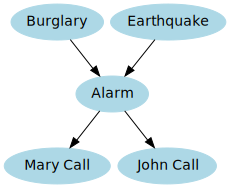

In [4]:
bn = BayesNetwork({'Alarm': alarm, 'Earthquake': earthquake, 'Mary Call': mcall, 'John Call': jcall, 'Burglary': burglary}, values=['True','False'])

bn.plot()

After creating the network you can run the **Ancestral Sampling algorithm** by calling the `sampling()` method. This method will return a dictionary with the name of the nodes as keys and the sampled values as values. The methods has three optional parameters: 
- `n_samples`: the number of samples to generate
- `init`: a dictionary of `(name, value)` that specifies the evidence to use for the sampling
- `seed`: the seed to use for the random number generator to reproduce the results

In [5]:
pp = pprint.PrettyPrinter(sort_dicts=False, indent=4)
samples = bn.sampling(5)
pp.pprint(samples)

Ancestral sampling 5 times from the network...

Topological ordering of nodes: ['Burglary', 'Earthquake', 'Alarm', 'Mary Call', 'John Call']

{   1: {   'Burglary': 'False',
           'Earthquake': 'False',
           'Alarm': 'False',
           'Mary Call': 'False',
           'John Call': 'False'},
    2: {   'Burglary': 'False',
           'Earthquake': 'False',
           'Alarm': 'False',
           'Mary Call': 'False',
           'John Call': 'False'},
    3: {   'Burglary': 'True',
           'Earthquake': 'False',
           'Alarm': 'True',
           'Mary Call': 'True',
           'John Call': 'False'},
    4: {   'Burglary': 'False',
           'Earthquake': 'False',
           'Alarm': 'False',
           'Mary Call': 'False',
           'John Call': 'False'},
    5: {   'Burglary': 'False',
           'Earthquake': 'False',
           'Alarm': 'False',
           'Mary Call': 'False',
           'John Call': 'False'}}


Then with the samples you can estimate the probability of a node given a set of evidences with the **Rejection Sampling algorithm** by calling the `estimate()` method. This method will return a dictionary with the name of the nodes as keys and the estimated probability as values. The methods has four parameters:
- `X`: the name of the node to estimate
- `x`: the value of the node to estimate
- `e`: a dictionary of `(name, value)` that specifies the evidence to use for the estimation
- `samples`: the samples to use for the estimation

In [6]:
pp.pprint(bn.estimate('Burglary', 'True', {'Alarm': 'True', 'Earthquake': 'False'}, samples))

{   'Burglary': {   'True': 1.0,
                    'evidence': {'Alarm': 'True', 'Earthquake': 'False'}}}


## Examples 
Below are shown two examples which use the classes implemented before, to define a Bayesian Network and perform ancestral sampling over them. The two examples are taken from real life problems and counts 10 nodes each. 

### COVID Diagnosis Example
In this example we want to build a Bayesian Network that can be used to diagnose COVID-19 with a subset of its symptoms. The network has 10 nodes and the structure can be defined as follows:

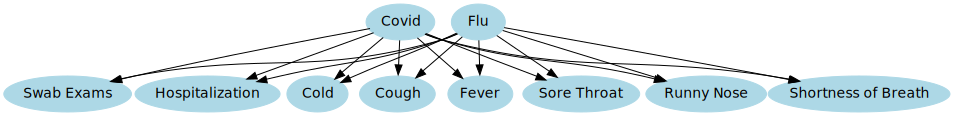

In [7]:
covid = Bnode(
    cpt= { 'p' : [0.05,0.95] },
    parents=None
)

flu = Bnode(
    cpt= { 'p' : [0.08,0.92] },
    parents=None
)

cough = Bnode(
    cpt= {
        ('True', 'True'): [0.95,0.05],
        ('True', 'False'): [0.7,0.3],
        ('False', 'True'): [0.9,0.1],
        ('False', 'False'): [0.2,0.8]
    },
    parents=['Covid','Flu'] 
)

fever = Bnode(
    cpt= {
        ('True', 'True'): [0.85,0.15],
        ('True', 'False'): [0.6,0.4],
        ('False', 'True'): [0.7,0.3],
        ('False', 'False'): [0.05,0.95]
    },
    parents=['Covid','Flu']
)

sore_throat = Bnode(
    cpt= {
        ('True', 'True'): [0.8,0.2],
        ('True', 'False'): [0.7,0.3],
        ('False', 'True'): [0.6,0.4],
        ('False', 'False'): [0.05,0.95]
    }, 
    parents=['Covid','Flu']
)

runny_nose = Bnode(
    cpt= {
        ('True', 'True'): [0.999,0.001],
        ('True', 'False'): [0.8,0.2],
        ('False', 'True'): [0.9,0.1],
        ('False', 'False'): [0.1,0.9]
    },
    parents=['Covid','Flu']
)

shortness_of_breath = Bnode(
    cpt= {
        ('True', 'True'): [0.85,0.15],
        ('True', 'False'): [0.6,0.4],
        ('False', 'True'): [0.2,0.8],
        ('False', 'False'): [0.001,0.999]
    },
    parents=['Covid','Flu']
)

cold = Bnode(
    cpt= {
        ('True', 'True'): [0.9,0.1],
        ('True', 'False'): [0.6,0.4],
        ('False', 'True'): [0.9,0.1],
        ('False', 'False'): [0.01,0.99]
    },
    parents=['Covid','Flu']
)

# true == positive, false == negative test result
swab_exams = Bnode(
    cpt= {
        ('True', 'True'): [0.995,0.005],
        ('True', 'False'): [0.995,0.005],
        ('False', 'True'): [0.05,0.95],
        ('False', 'False'): [0.01,0.99]
    },
    parents=['Covid','Flu']
)

hospitalization = Bnode(
    cpt= {
        ('True', 'True'): [0.4,0.6],
        ('True', 'False'): [0.3,0.7],
        ('False', 'True'): [0.1,0.9],
        ('False', 'False'): [0.05,0.95]
    },
    parents=['Covid','Flu']
)
    
# create the BN
cbn = BayesNetwork({'Covid': covid, 
                    'Flu': flu,
                    'Cold': cold, 
                    'Cough': cough, 
                    'Fever': fever, 
                    'Sore Throat': sore_throat, 
                    'Runny Nose': runny_nose, 
                    'Shortness of Breath': shortness_of_breath,
                    'Swab Exams': swab_exams,
                    'Hospitalization': hospitalization}, 
                    values=['True','False'])

# plot the BN
cbn.plot()

The prior probability of having Covid [1] and Flu [2] are taken from the website of [Ministero della Salute](https://www.salute.gov.it/) and can be consulted at the links [[1]](https://www.salute.gov.it/portale/nuovocoronavirus/dettaglioContenutiNuovoCoronavirus.jsp?lingua=italiano&id=5351&area=nuovoCoronavirus&menu=vu) and [[2]](https://www.salute.gov.it/portale/influenza/dettaglioContenutiInfluenza.jsp?lingua=italiano&id=685&area=influenza&menu=vuoto). The other conditional probabilities instead are defined by means of my prior knowledge.

Then some episoded of ancestral sampling can be performed over the network.

In [8]:
# ancestral sampling 
pp = pprint.PrettyPrinter(sort_dicts=False)
samples = cbn.sampling(1000)
pp.pprint(samples)

Ancestral sampling 1000 times from the network...

Topological ordering of nodes: ['Covid', 'Flu', 'Cold', 'Cough', 'Fever', 'Sore Throat', 'Runny Nose', 'Shortness of Breath', 'Swab Exams', 'Hospitalization']

{1: {'Covid': 'False',
     'Flu': 'False',
     'Cold': 'False',
     'Cough': 'False',
     'Fever': 'False',
     'Sore Throat': 'False',
     'Runny Nose': 'False',
     'Shortness of Breath': 'False',
     'Swab Exams': 'False',
     'Hospitalization': 'False'},
 2: {'Covid': 'False',
     'Flu': 'False',
     'Cold': 'False',
     'Cough': 'True',
     'Fever': 'False',
     'Sore Throat': 'False',
     'Runny Nose': 'False',
     'Shortness of Breath': 'False',
     'Swab Exams': 'False',
     'Hospitalization': 'False'},
 3: {'Covid': 'False',
     'Flu': 'False',
     'Cold': 'False',
     'Cough': 'True',
     'Fever': 'False',
     'Sore Throat': 'False',
     'Runny Nose': 'False',
     'Shortness of Breath': 'False',
     'Swab Exams': 'False',
     'Hospitalization

The probability that the sampling generates a particular sequence is given by the product of the conditional probabilities of the nodes in the sequence. So the sampling can be used to observe the most common sequence related to Covid and Flu. We can also use the sampling to estimate the probability of having Covid or Flu given a subset of their symptoms with rejection sampling.

In [9]:
prob_covid = cbn.estimate('Covid','True',{'Hospitalization': 'True', 'Cough': 'True'}, samples)
prob_flu = cbn.estimate('Flu','True',{'Hospitalization': 'True', 'Cough': 'True'}, samples)

pp.pprint(prob_covid)
pp.pprint(prob_flu)

{'Covid': {'True': 0.22727272727272727,
           'evidence': {'Hospitalization': 'True', 'Cough': 'True'}}}
{'Flu': {'True': 0.5, 'evidence': {'Hospitalization': 'True', 'Cough': 'True'}}}


Increasing the number of samples the estimated probability will converge to the true full joint probability. The problem with this approach is that the number of samples needed to converge to the true probability is very high and the sampling can be very slow according to the number of nodes in the network. Also if the probability of the evidences is very low the sampling will take a lot of time due to the number of sampling discarded.

### Daily Routine Example
In this example a Bayesian Network is defined to represent a subset of the causal relation which characterize my daily routine. The network has 10 nodes with a multinomial probability of [1,2,3] which correspond to the activity performance ( e.g how much traffic intensity, how much delay, how much sleep, how well study, ...).

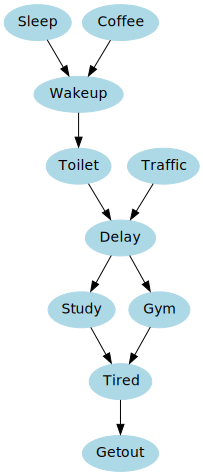

In [10]:
sleep = Bnode(
    cpt= { 'p' : [0.2,0.5,0.3] },
    parents=None
)

coffee = Bnode(
    cpt= { 'p' : [0.1,0.6,0.3] },
    parents=None
)

wakeup = Bnode(
    cpt= {
        ('1', '1'): [0.9,0.05,0.05],
        ('1', '2'): [0.4,0.4,0.2],
        ('1', '3'): [0.2,0.4,0.4],
        ('2', '1'): [0.1,0.6,0.3],
        ('2', '2'): [0.05,0.7,0.25],
        ('2', '3'): [0.05,0.4,0.55],
        ('3', '1'): [0.1,0.8,0.1],
        ('3', '2'): [0.05,0.5,0.45],
        ('3', '3'): [0.01,0.3,0.69]
    },
    parents=['Sleep','Coffee']
)

toilet = Bnode(
    cpt= {
        ('1',): [0.98,0.01,0.01],
        ('2',): [0.5,0.4,0.1],
        ('3',): [0.1,0.5,0.4]
    },
    parents=['Wakeup']
)

traffic = Bnode(
    cpt= { 'p' : [0.25,0.5,0.25] },
    parents=None
)

delay = Bnode(
    cpt= { 
        ('1', '1'): [0.4,0.4,0.2],
        ('1', '2'): [0.2,0.5,0.3],
        ('1', '3'): [0.1,0.2,0.7],
        ('2', '1'): [0.1,0.6,0.3],
        ('2', '2'): [0.05,0.7,0.25],
        ('2', '3'): [0.05,0.05,0.9],
        ('3', '1'): [0.1,0.8,0.1],
        ('3', '2'): [0.05,0.5,0.45],
        ('3', '3'): [0.01,0.01,0.98]
    },  
    parents=['Toilet','Traffic']
)

study = Bnode(
    cpt= {
        ('1',): [0.9,0.05,0.05],
        ('2',): [0.5,0.4,0.1],
        ('3',): [0.1,0.5,0.4]
    },
    parents=['Delay']
)

gym = Bnode(
    cpt= {
        ('1',): [0.9,0.05,0.05],
        ('2',): [0.5,0.4,0.1],
        ('3',): [0.1,0.5,0.4]
    },
    parents=['Delay']
)

tired = Bnode(
    cpt= {
        ('1','1'): [0.9,0.05,0.05],
        ('1','2'): [0.5,0.4,0.1],
        ('1','3'): [0.1,0.5,0.4],
        ('2','1'): [0.9,0.05,0.05],
        ('2','2'): [0.5,0.4,0.1],
        ('2','3'): [0.1,0.5,0.4],
        ('3','1'): [0.9,0.05,0.05],
        ('3','2'): [0.5,0.4,0.1],
        ('3','3'): [0.1,0.5,0.4]
    },
    parents=['Study','Gym']
)

getout = Bnode(
    cpt= { 
        ('1',): [0.9,0.05,0.05],
        ('2',): [0.5,0.4,0.1],
        ('3',): [0.1,0.5,0.4]
    },
    parents=['Tired']
)

# create the BN
dbn = BayesNetwork({'Sleep': sleep,
                    'Coffee': coffee,
                    'Wakeup': wakeup,
                    'Toilet': toilet,
                    'Traffic': traffic,
                    'Delay': delay,
                    'Study': study,
                    'Gym': gym,
                    'Tired': tired,
                    'Getout': getout},
                    values=['1','2','3'])

# plot the BN
dbn.plot()

Also in this case some episoded of ancestral sampling can be performed over the network.

In [11]:
# ancestral sampling
samples = dbn.sampling(1000)
pp.pprint(samples)

Ancestral sampling 1000 times from the network...

Topological ordering of nodes: ['Sleep', 'Coffee', 'Traffic', 'Wakeup', 'Toilet', 'Delay', 'Study', 'Gym', 'Tired', 'Getout']

{1: {'Sleep': '2',
     'Coffee': '3',
     'Traffic': '2',
     'Wakeup': '2',
     'Toilet': '1',
     'Delay': '2',
     'Study': '1',
     'Gym': '1',
     'Tired': '1',
     'Getout': '2'},
 2: {'Sleep': '3',
     'Coffee': '3',
     'Traffic': '2',
     'Wakeup': '2',
     'Toilet': '2',
     'Delay': '3',
     'Study': '2',
     'Gym': '2',
     'Tired': '2',
     'Getout': '2'},
 3: {'Sleep': '2',
     'Coffee': '2',
     'Traffic': '3',
     'Wakeup': '2',
     'Toilet': '2',
     'Delay': '1',
     'Study': '3',
     'Gym': '1',
     'Tired': '1',
     'Getout': '1'},
 4: {'Sleep': '2',
     'Coffee': '2',
     'Traffic': '2',
     'Wakeup': '2',
     'Toilet': '1',
     'Delay': '1',
     'Study': '3',
     'Gym': '1',
     'Tired': '1',
     'Getout': '1'},
 5: {'Sleep': '3',
     'Coffee': '3',
   

Then, for example, the probability `P(Study=3 | Wakeup=1,Sleep=1,Coffee=2)` of performing well in Study given that i sleep bad, didn't get out of bed and had the right amount of coffee can be estimated.

In [17]:
#  P(Study=3 | Wakeup=1,Sleep=1,Coffee=2) estimate the probability of study well given that i sleep bad, didn't get out of bed and had the right amount of coffee
prob_study = dbn.estimate('Study','3',{'Wakeup': '1', 'Sleep': '1', 'Coffee': '2'}, samples)
pp.pprint(prob_study)


{'Study': {'3': 0.19230769230769232,
           'evidence': {'Wakeup': '1', 'Sleep': '1', 'Coffee': '2'}}}


## Final Considerations

For this assignment we needed to implement from scratch a Bayesian Network and run the Ancestral Sampling algorithm. First i implement the two class `Bnode` and `BayesianNetwork` which represent a node and a Bayesian Network respectively. Then i implement the `sampling()` and `estimate()` methods of the class `BayesianNetwork` which are used to run the Ancestral Sampling algorithm and the Rejection Sampling algorithm respectively. Finally i use the classes to define two Bayesian Networks and run some examples of ancestral sampling over them. The two examples shows how the classes can be used to represent a real life problem and how the ancestral sampling can be used to estimate the full joint probability. 

This assignment give me a better understanding of Bayesian Networks and ancestral smapling. It was a great opportunity to try by hand a topic which is fundamental in all our course. I used the networkx and graphviz modules to represent the network and the numpy module to sample from distribution.

The library can be improved by adding more Bayesian Network algorithms (joint probability, marginal probability, inference, etc) and by adding network manipulation methods (add/remove nodes, add/remove edges, etc). Also the experiments can be improved by using more complex networks, more accurate probability distribution and more samples.